# pySCENIC protocol: PBMC10k downstream analyses

July 2019

Dataset: *10k PBMCs from a Healthy Donor* available from 10x Genomics ([here](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_v3)).

In [3]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization

/usr/local/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/usr/local/lib/python3.6/site-packages/louvain/Optimiser.py:349: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(issubclass(partition_type, LinearResolutionParameterVertexPartition),


In [4]:
# set variables for file paths to read from and write to:

# set a working directory
wdir = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/testruns/scenic-protocol/prottest3/"
os.chdir( wdir )


# path to loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'pbmc10k_scenic_integrated-output.loom'

In [5]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=120)

scanpy==1.4.4 anndata==0.6.22 umap==0.3.9 numpy==1.16.2 scipy==1.3.0 pandas==0.23.4 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


In [6]:
# scenic output
lf = lp.connect( f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
#regulons = lf.ra.Regulons
###

In [7]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

In [8]:
cellAnnot = pd.concat(
    [
        pd.DataFrame( lf.ca.Celltype_Garnett, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.ClusterID, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Louvain_clusters_Scanpy, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Percent_mito, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nGene, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nUMI, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'Celltype_Garnett',
 'ClusterID',
 'Louvain_clusters_Scanpy',
 'Percent_mito',
 'nGene',
 'nUMI']

In [9]:
lf.close()

---
# Regulon specificity scores (RSS) across predicted cell types

In [10]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

### Calculate RSS

In [11]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['Celltype_Garnett'] )
rss_cellType

AHR_(+)    AR_(+)  ARNT_(+)  ARNTL_(+)  ARNTL2_(+)  \
CD4 T cells      0.201368  0.103689  0.148700   0.251208    0.142663   
Monocytes        0.300823  0.097081  0.144484   0.189905    0.121409   
NK cells         0.124409  0.101166  0.105679   0.135087    0.111172   
B cells          0.154361  0.093002  0.139682   0.168305    0.227722   
Unknown          0.136270  0.098989  0.122558   0.150398    0.124193   
T cells          0.119665  0.094274  0.112568   0.133800    0.110948   
Dendritic cells  0.098939  0.223749  0.094273   0.096750    0.107046   
CD8 T cells      0.100752  0.091901  0.098404   0.108070    0.100187   
CD34+            0.089496  0.088977  0.090867   0.089668    0.088664   

                 ASCL2_(+)  ATF1_(+)  ATF2_(+)  ATF3_(+)  ATF4_(+)    ...     \
CD4 T cells       0.217423  0.248175  0.234989  0.207929  0.236648    ...      
Monocytes         0.141229  0.209673  0.230489  0.291887  0.231322    ...      
NK cells          0.189977  0.133927  0.123651  0.128560  0.131449    ...      
B cells           0.128129  0.169110  0.152949  0.151243  0.167001    ...      
Unknown           0.160275  0.148597  0.141748  0.138170  0.146602    ...      
T cells           0.133412  0.132041  0.129222  0.121049  0.129339    ...      
Dendritic cells   0.092803  0.099127  0.096358  0.098181  0.100761    ...      
CD8 T cells       0.115621  0.107526  0.105230  0.101766  0.105846    ...      
CD34+             0.089384  0.089734  0.090162  0.089409  0.090004    ...      

                 ZNF775_(+)  ZNF8_(+)  ZNF81_(+)  ZNF816_(+)  ZNF83_(+)  \
CD4 T cells        0.128018  0.167161   0.247979    0.211727   0.177778   
Monocytes          0.105743  0.132576   0.141749    0.118760   0.105149   
NK cells           0.095182  0.106276   0.116358    0.135330   0.141067   
B cells            0.130938  0.178900   0.198672    0.165151   0.128724   
Unknown            0.105029  0.124500   0.145900    0.147075   0.146721   
T cells            0.104712  0.119528   0.132525    0.134446   0.126969   
Dendritic cells    0.088842  0.092529   0.095620    0.092624   0.090935   
CD8 T cells        0.095561  0.101254   0.106399    0.110230   0.110368   
CD34+              0.087556  0.088101   0.090472    0.089477   0.092952   

                 ZNF831_(+)  ZNF91_(+)  ZSCAN2_(+)  ZSCAN31_(+)  ZXDB_(+)  
CD4 T cells        0.289053   0.264924    0.158685     0.139297  0.193127  
Monocytes          0.152881   0.181063    0.122365     0.120651  0.212910  
NK cells           0.129218   0.127088    0.113082     0.106110  0.116509  
B cells            0.161620   0.173518    0.146479     0.161337  0.150870  
Unknown            0.153233   0.150005    0.121861     0.131266  0.135631  
T cells            0.140204   0.137548    0.113163     0.113123  0.120517  
Dendritic cells    0.093907   0.097483    0.092129     0.095879  0.093295  
CD8 T cells        0.110154   0.107967    0.098949     0.102372  0.101265  
CD34+              0.089296   0.089741    0.088258     0.088908  0.089879  

[9 rows x 389 columns]

### RSS panel plot with all cell types

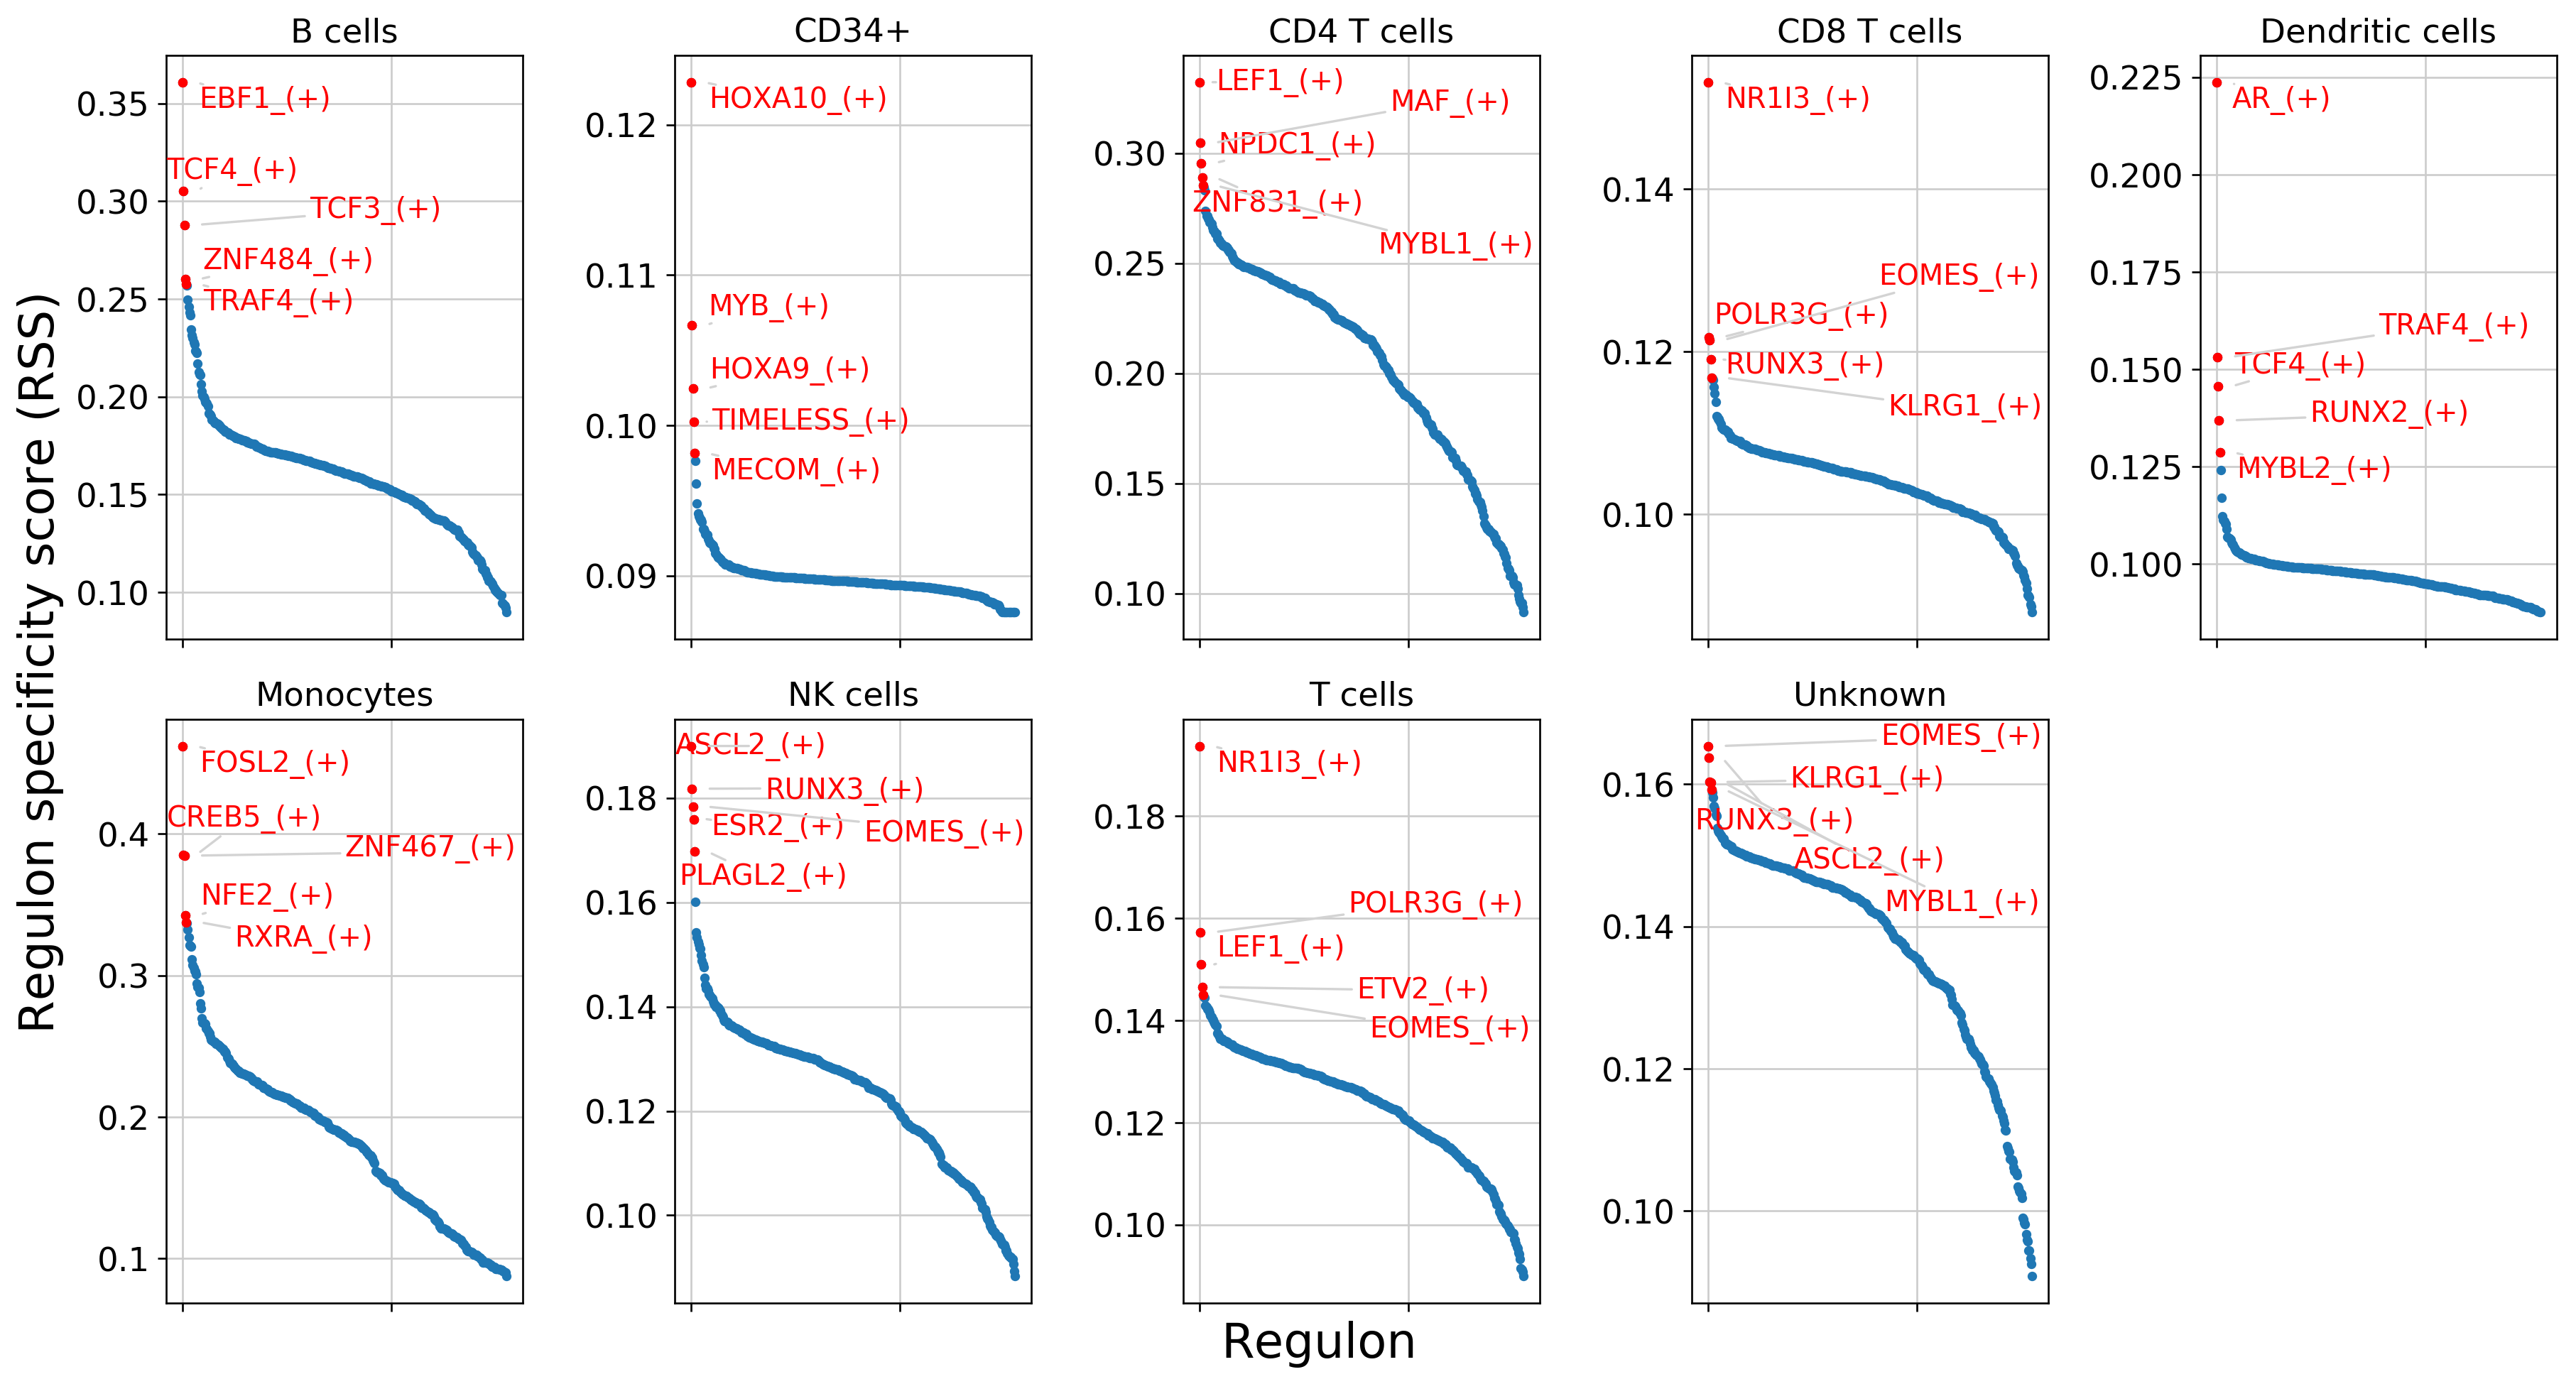

In [12]:
cats = sorted(list(set(cellAnnot['Celltype_Garnett'])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(2,5,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        #'axes.labelsize': 'x-large',
        #'axes.titlesize':'x-large',
        'xtick.labelsize':'large',
        'ytick.labelsize':'large'
        })
plt.savefig("PBMC10k_cellType-RSS-top5.png", dpi=150, bbox_inches = "tight")
plt.show()

### Select the top 5 regulons from each cell type

In [13]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

Aggregate the AUC matrix by cell type:

In [14]:
auc_mtx_celltype = auc_mtx.groupby(cellAnnot['Celltype_Garnett'],axis=0).mean()
auc_mtx_celltype

AHR_(+)    AR_(+)  ARNT_(+)  ARNTL_(+)  ARNTL2_(+)  \
Celltype_Garnett                                                        
B cells           0.038584  0.000482  0.012697   0.029278    0.036626   
CD34+             0.042450  0.001611  0.020820   0.027888    0.007749   
CD4 T cells       0.035593  0.000825  0.009705   0.033316    0.008770   
CD8 T cells       0.032178  0.000810  0.009058   0.032733    0.011382   
Dendritic cells   0.044982  0.052809  0.007935   0.020790    0.029820   
Monocytes         0.070816  0.000500  0.008918   0.018196    0.005006   
NK cells          0.035788  0.001301  0.006640   0.029598    0.009293   
T cells           0.035100  0.000677  0.010068   0.032917    0.010208   
Unknown           0.037982  0.001113  0.010901   0.031344    0.012713   

                  ASCL2_(+)  ATF1_(+)  ATF2_(+)  ATF3_(+)  ATF4_(+)    ...     \
Celltype_Garnett                                                       ...      
B cells            0.017198  0.039616  0.041312  0.037290  0.056637    ...      
CD34+              0.031331  0.038784  0.059834  0.041461  0.065805    ...      
CD4 T cells        0.034323  0.043169  0.051692  0.039089  0.058318    ...      
CD8 T cells        0.059775  0.042489  0.047362  0.036163  0.056534    ...      
Dendritic cells    0.014514  0.036418  0.034192  0.042507  0.063336    ...      
Monocytes          0.011753  0.029385  0.046798  0.069410  0.052885    ...      
NK cells           0.102116  0.037790  0.036898  0.041800  0.052083    ...      
T cells            0.042140  0.042122  0.050356  0.037950  0.057550    ...      
Unknown            0.051172  0.040080  0.045993  0.040802  0.056757    ...      

                  ZNF775_(+)  ZNF8_(+)  ZNF81_(+)  ZNF816_(+)  ZNF83_(+)  \
Celltype_Garnett                                                           
B cells             0.011406  0.027918   0.041035    0.041572   0.013827   
CD34+               0.000000  0.004204   0.036134    0.030126   0.048586   
CD4 T cells         0.008122  0.014736   0.031863    0.039454   0.018251   
CD8 T cells         0.006219  0.014002   0.027671    0.049178   0.026370   
Dendritic cells     0.001111  0.007294   0.017024    0.015254   0.005565   
Monocytes           0.003304  0.007731   0.009533    0.008780   0.003196   
NK cells            0.002512  0.008352   0.015755    0.041985   0.028935   
T cells             0.007380  0.016418   0.029806    0.045858   0.022628   
Unknown             0.006393  0.013905   0.027552    0.041152   0.025091   

                  ZNF831_(+)  ZNF91_(+)  ZSCAN2_(+)  ZSCAN31_(+)  ZXDB_(+)  
Celltype_Garnett                                                            
B cells             0.070651   0.043228    0.011351     0.021016  0.026404  
CD34+               0.060298   0.039847    0.003458     0.008320  0.031111  
CD4 T cells         0.112956   0.049730    0.008759     0.009596  0.025548  
CD8 T cells         0.098803   0.044589    0.007017     0.013612  0.022678  
Dendritic cells     0.036755   0.031088    0.004348     0.011115  0.013355  
Monocytes           0.028538   0.021997    0.004204     0.006129  0.029246  
NK cells            0.068411   0.031897    0.007062     0.007635  0.019066  
T cells             0.104119   0.049691    0.008127     0.011676  0.024992  
Unknown             0.090821   0.042706    0.008579     0.016209  0.026376  

[9 rows x 389 columns]

### Create a heatmap of the top 5 regulons for each cell type, showing the aggregate AUC values

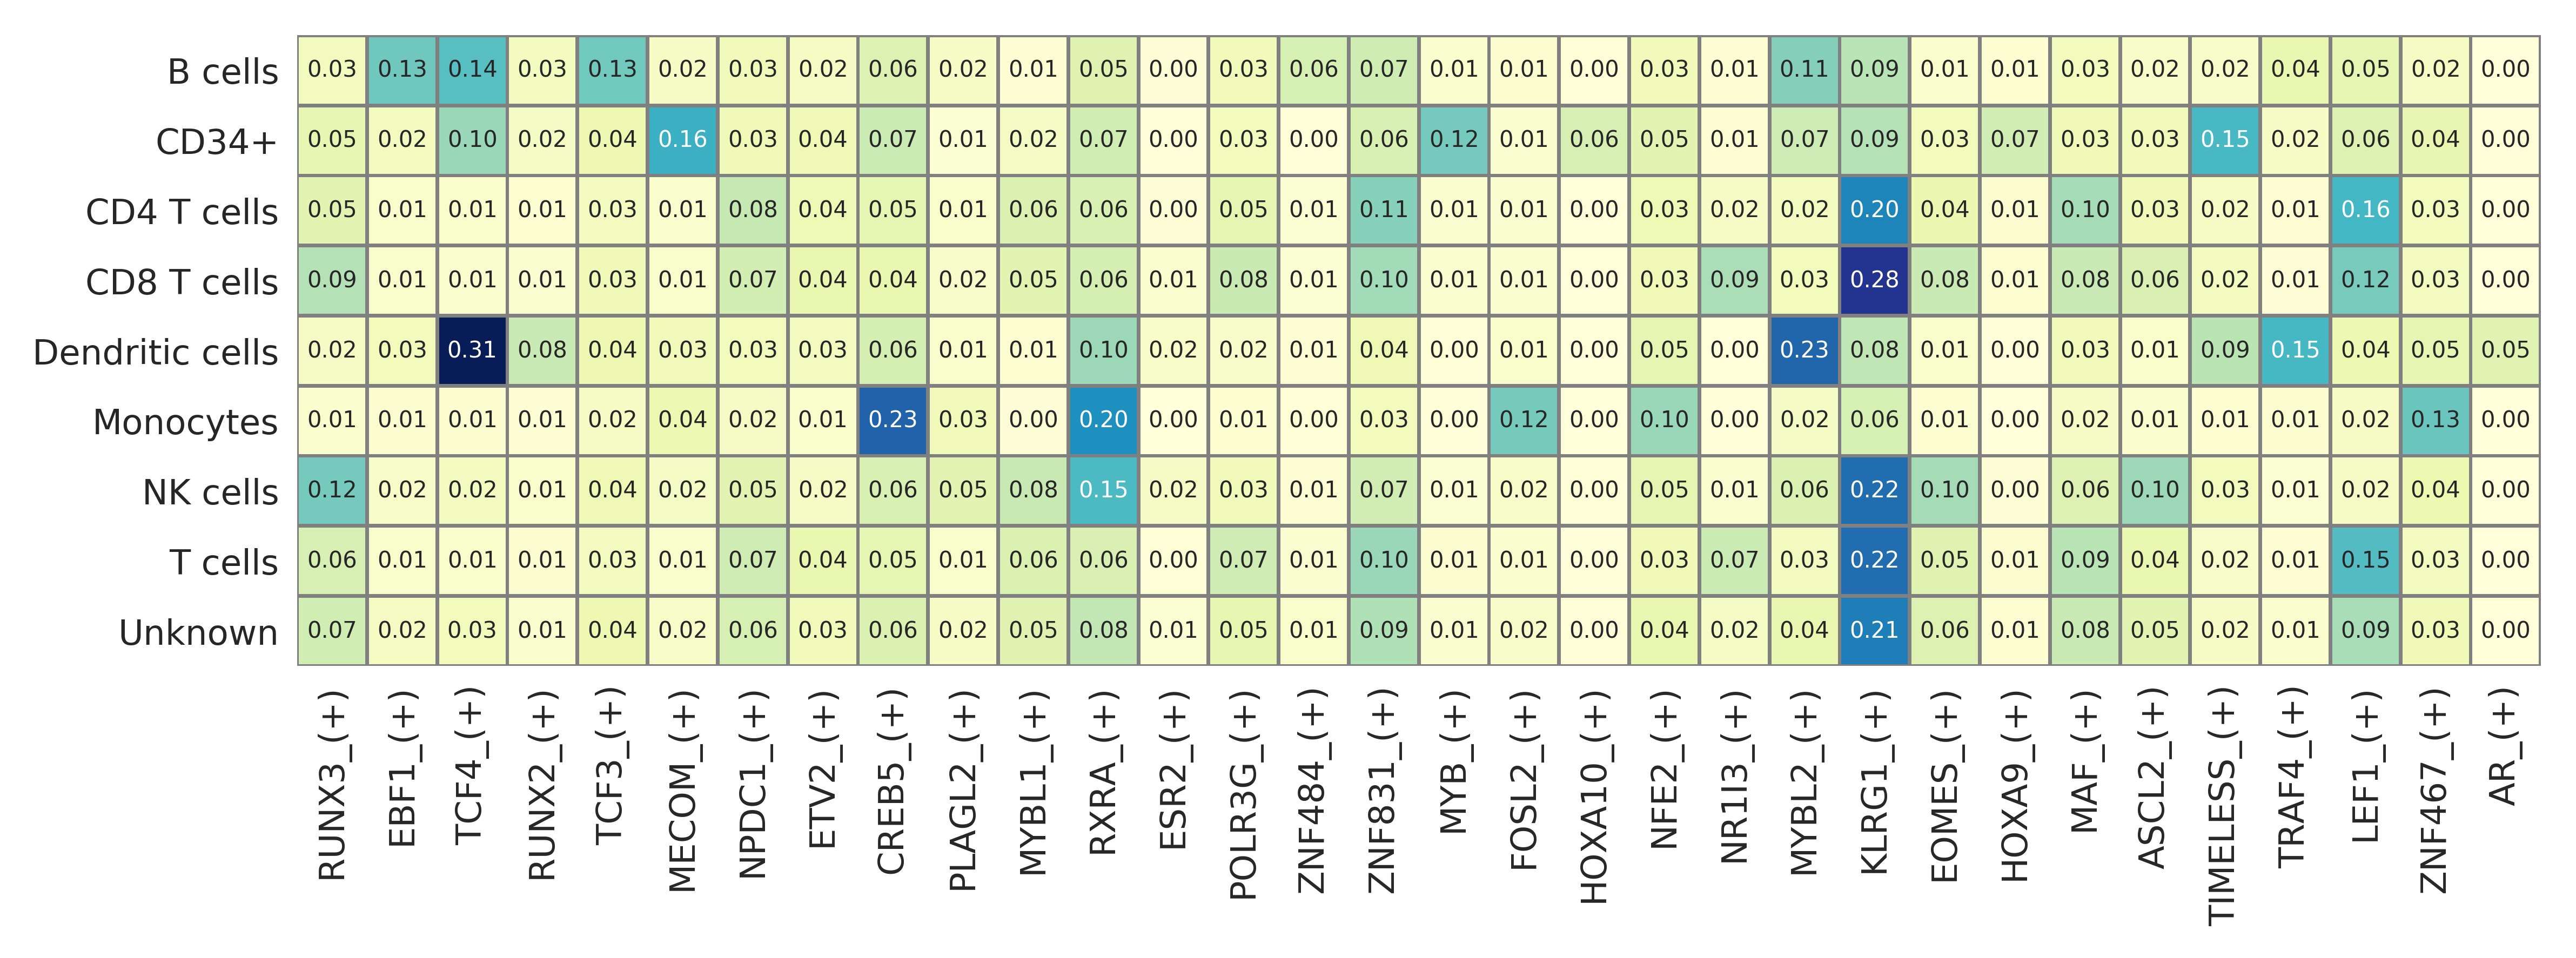

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (8,8), dpi=300)
sns.heatmap(auc_mtx_celltype[topreg], ax=ax, annot=True, fmt=".2f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
            cmap="YlGnBu", annot_kws={"size": 5})
ax.tick_params(axis='both', which='major', pad=-2)
sns.set(font_scale=0.7)
ax.set_ylabel('')    
ax.set_xlabel('')

plt.tight_layout()
plt.savefig("PBMC10k_cellType-AUC-heatmap-top5.png", dpi=150, bbox_inches = "tight")
plt.show()

#### Add clustering to the heatmap

Text(0.5, 54.50000000000002, '')

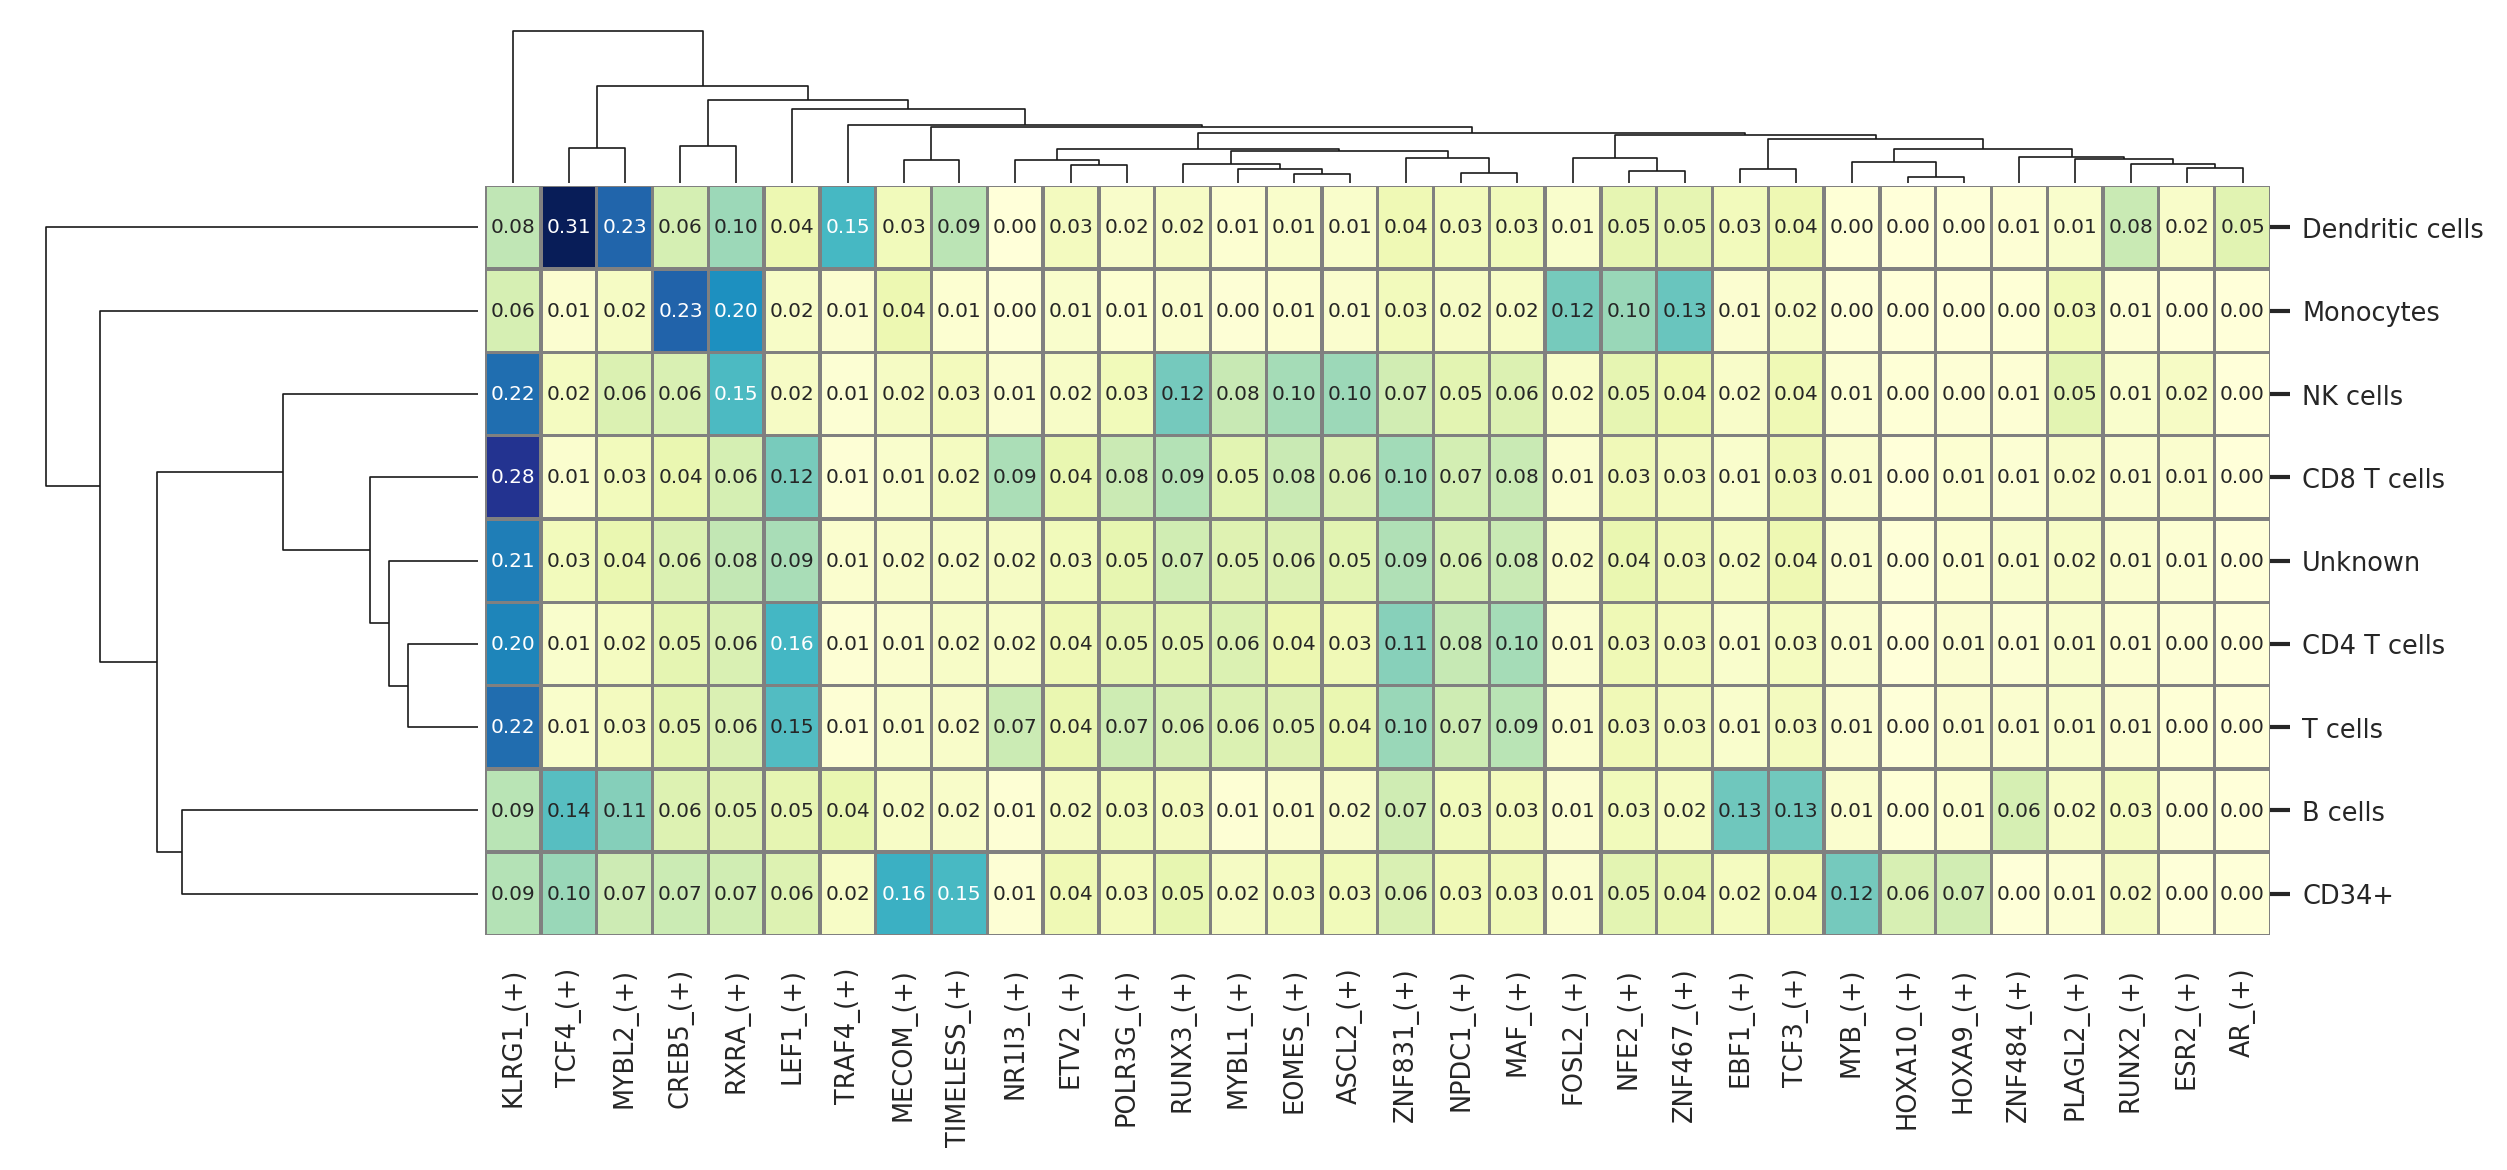

In [17]:
g = sns.clustermap(auc_mtx_celltype[topreg], annot=True, fmt=".2f", linewidths=.7, cbar=False, square=False, linecolor='gray', 
            cmap="YlGnBu", annot_kws={"size": 6}, figsize=(12,5) )
sns.set(font_scale=0.7)
g.cax.set_visible(False)
g.ax_heatmap.set_ylabel('')    
g.ax_heatmap.set_xlabel('')    

### Generate a binary regulon activity matrix using only the top regulons:

In [18]:
binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=25 )
binary_mtx.head()

AHR_(+)  AR_(+)  ARNT_(+)  ARNTL_(+)  ARNTL2_(+)  \
AAACCCAAGCGCCCAT-1        0       0         1          0           0   
AAACCCACAGAGTTGG-1        1       0         0          0           0   
AAACCCACAGGTATGG-1        0       0         0          0           0   
AAACCCACATAGTCAC-1        0       0         1          0           0   
AAACCCACATCCAATG-1        0       0         0          0           0   

                    ASCL2_(+)  ATF1_(+)  ATF2_(+)  ATF3_(+)  ATF4_(+)  \
AAACCCAAGCGCCCAT-1          0         0         1         0         0   
AAACCCACAGAGTTGG-1          0         0         0         1         0   
AAACCCACAGGTATGG-1          1         0         0         0         0   
AAACCCACATAGTCAC-1          0         0         0         0         0   
AAACCCACATCCAATG-1          1         0         0         0         0   

                      ...     ZNF775_(+)  ZNF8_(+)  ZNF81_(+)  ZNF816_(+)  \
AAACCCAAGCGCCCAT-1    ...              1         0          0           0   
AAACCCACAGAGTTGG-1    ...              0         0          0           0   
AAACCCACAGGTATGG-1    ...              0         1          0           1   
AAACCCACATAGTCAC-1    ...              0         1          1           1   
AAACCCACATCCAATG-1    ...              0         0          0           1   

                    ZNF83_(+)  ZNF831_(+)  ZNF91_(+)  ZSCAN2_(+)  ZSCAN31_(+)  \
AAACCCAAGCGCCCAT-1          0           1          0           0            0   
AAACCCACAGAGTTGG-1          0           0          0           0            0   
AAACCCACAGGTATGG-1          0           1          0           0            0   
AAACCCACATAGTCAC-1          0           1          0           0            0   
AAACCCACATCCAATG-1          0           1          0           0            0   

                    ZXDB_(+)  
AAACCCAAGCGCCCAT-1         1  
AAACCCACAGAGTTGG-1         1  
AAACCCACAGGTATGG-1         0  
AAACCCACATAGTCAC-1         1  
AAACCCACATCCAATG-1         0  

[5 rows x 389 columns]

### Show the AUC distributions for selected regulons

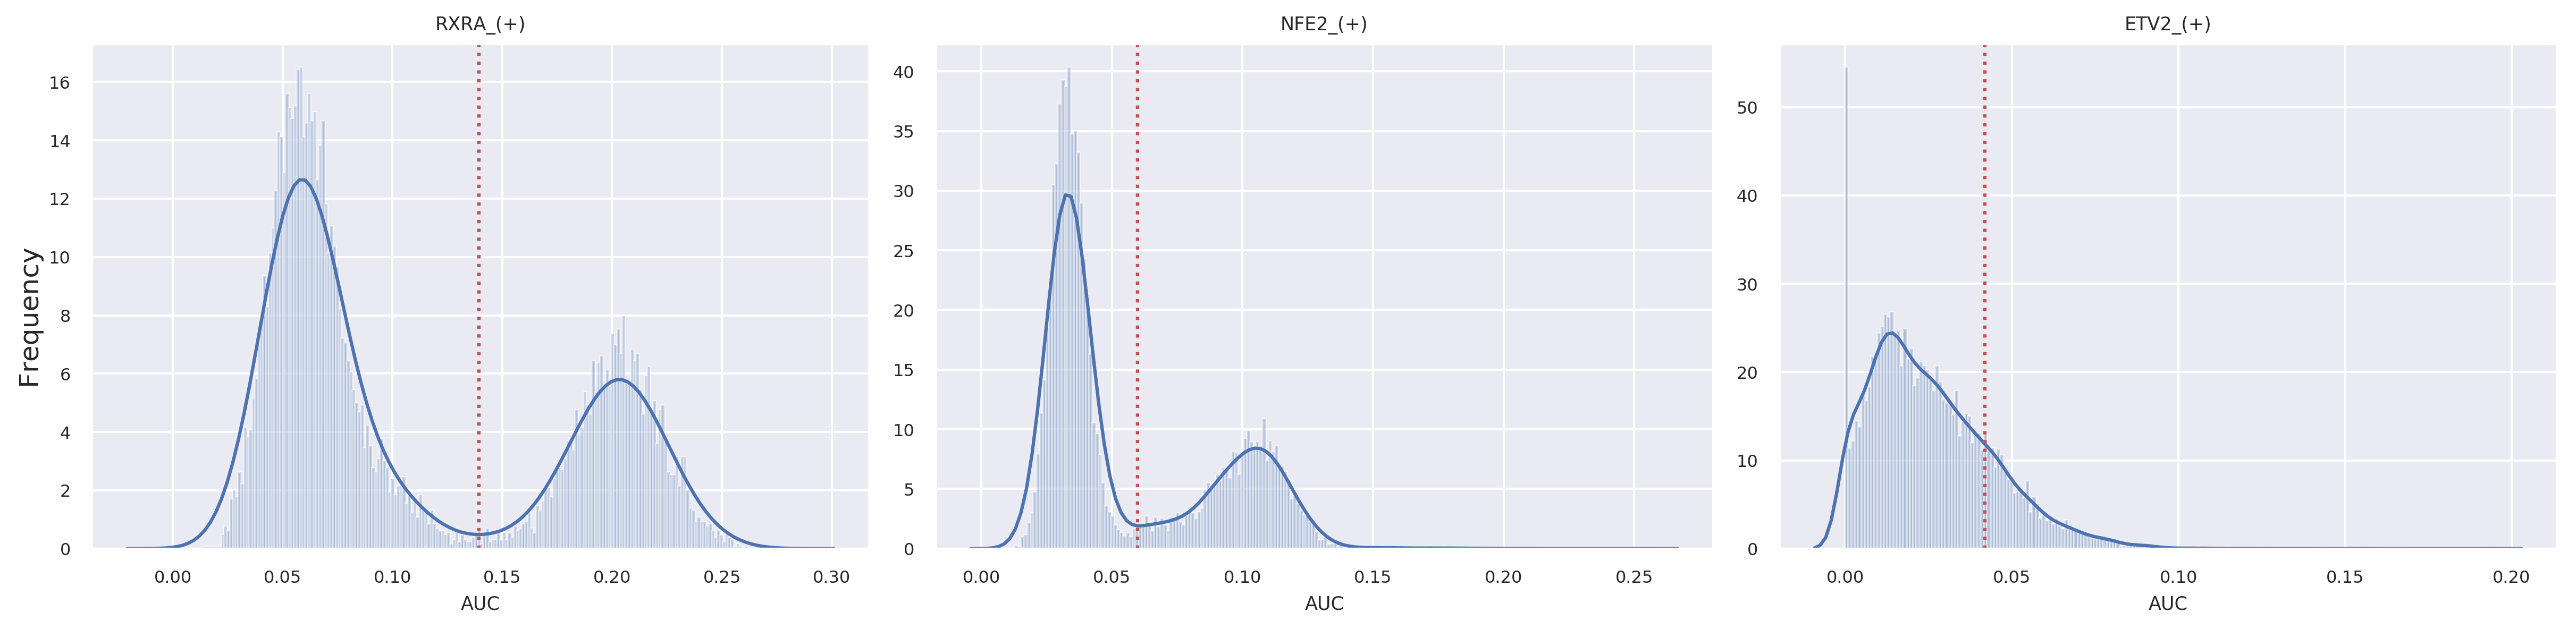

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), dpi=150)

plot_binarization(auc_mtx, 'RXRA_(+)', auc_thresholds['RXRA_(+)'], ax=ax1)
plot_binarization(auc_mtx, 'NFE2_(+)', auc_thresholds['NFE2_(+)'], ax=ax2)
plot_binarization(auc_mtx, 'ETV2_(+)', auc_thresholds['ETV2_(+)'], ax=ax3)

ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
fig.text(0.00, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()
fig.savefig("PBMC10k_cellType-binaryPlot.png", dpi=150, bbox_inches = "tight")
#plt.show()

---
# Regulon specificity scores (RSS) across Louvain clusters

### Calculate RSS

In [19]:
rss_louvain = regulon_specificity_scores( auc_mtx, cellAnnot['Louvain_clusters_Scanpy'] )
rss_louvain

AHR_(+)    AR_(+)  ARNT_(+)  ARNTL_(+)  ARNTL2_(+)  ASCL2_(+)  ATF1_(+)  \
0   0.159392  0.097818  0.127536   0.188638    0.120586   0.161279  0.185316   
1   0.213009  0.094700  0.134562   0.151186    0.115057   0.119756  0.160720   
7   0.113132  0.105330  0.106170   0.134567    0.114812   0.215087  0.128194   
3   0.153897  0.093194  0.140235   0.167474    0.230783   0.126388  0.168608   
5   0.122757  0.093707  0.113812   0.138706    0.115160   0.145726  0.137913   
2   0.197804  0.092167  0.115129   0.140944    0.102181   0.115660  0.152870   
4   0.145508  0.100145  0.137059   0.169104    0.129916   0.139598  0.170535   
11  0.100402  0.220243  0.095206   0.097102    0.107310   0.091934  0.100190   
6   0.121422  0.100413  0.111303   0.141422    0.111737   0.170230  0.134724   
8   0.112058  0.088556  0.096851   0.104195    0.092641   0.104384  0.109038   
10  0.101158  0.101494  0.100756   0.097174    0.095953   0.099489  0.098619   
9   0.101890  0.087556  0.095484   0.107415    0.099885   0.110761  0.105992   

    ATF2_(+)  ATF3_(+)  ATF4_(+)    ...     ZNF775_(+)  ZNF8_(+)  ZNF81_(+)  \
0   0.175680  0.162971  0.180157    ...       0.111493  0.138481   0.188064   
1   0.171981  0.208362  0.170611    ...       0.104420  0.127705   0.123744   
7   0.118591  0.117273  0.123795    ...       0.091727  0.109601   0.114908   
3   0.152048  0.150577  0.166065    ...       0.131724  0.178972   0.198390   
5   0.134312  0.124766  0.134511    ...       0.100780  0.120844   0.137892   
2   0.169564  0.194399  0.165311    ...       0.095811  0.106173   0.114288   
4   0.163953  0.147685  0.161122    ...       0.136491  0.146271   0.180994   
11  0.098221  0.099493  0.102387    ...       0.087871  0.091194   0.096225   
6   0.134344  0.125033  0.133214    ...       0.094256  0.115694   0.125137   
8   0.106087  0.113513  0.110289    ...       0.095770  0.093493   0.099606   
10  0.091414  0.098659  0.102858    ...       0.096189  0.091410   0.097783   
9   0.107285  0.102617  0.106595    ...       0.093495  0.100163   0.109674   

    ZNF816_(+)  ZNF83_(+)  ZNF831_(+)  ZNF91_(+)  ZSCAN2_(+)  ZSCAN31_(+)  \
0     0.157219   0.145482    0.211948   0.194600    0.153336     0.112113   
1     0.109033   0.101477    0.127008   0.144890    0.115035     0.116495   
7     0.146402   0.167863    0.131350   0.124455    0.107322     0.115848   
3     0.164106   0.128871    0.160243   0.172826    0.145950     0.161529   
5     0.144295   0.134911    0.145760   0.143303    0.112428     0.112711   
2     0.101441   0.093643    0.123685   0.137528    0.101082     0.094957   
4     0.164440   0.147893    0.178150   0.182132    0.121445     0.137187   
11    0.092064   0.091444    0.093797   0.097974    0.089046     0.094476   
6     0.136583   0.130274    0.153774   0.135333    0.114400     0.119116   
8     0.095132   0.091731    0.100074   0.103968    0.104616     0.088921   
10    0.106914   0.100226    0.091632   0.094444    0.118325     0.136258   
9     0.105690   0.100988    0.113077   0.109492    0.094866     0.094609   

    ZXDB_(+)  
0   0.155554  
1   0.174125  
7   0.117275  
3   0.151178  
5   0.121257  
2   0.148633  
4   0.153885  
11  0.093208  
6   0.118760  
8   0.099982  
10  0.107993  
9   0.097441  

[12 rows x 389 columns]

### RSS panel plot with all cell types

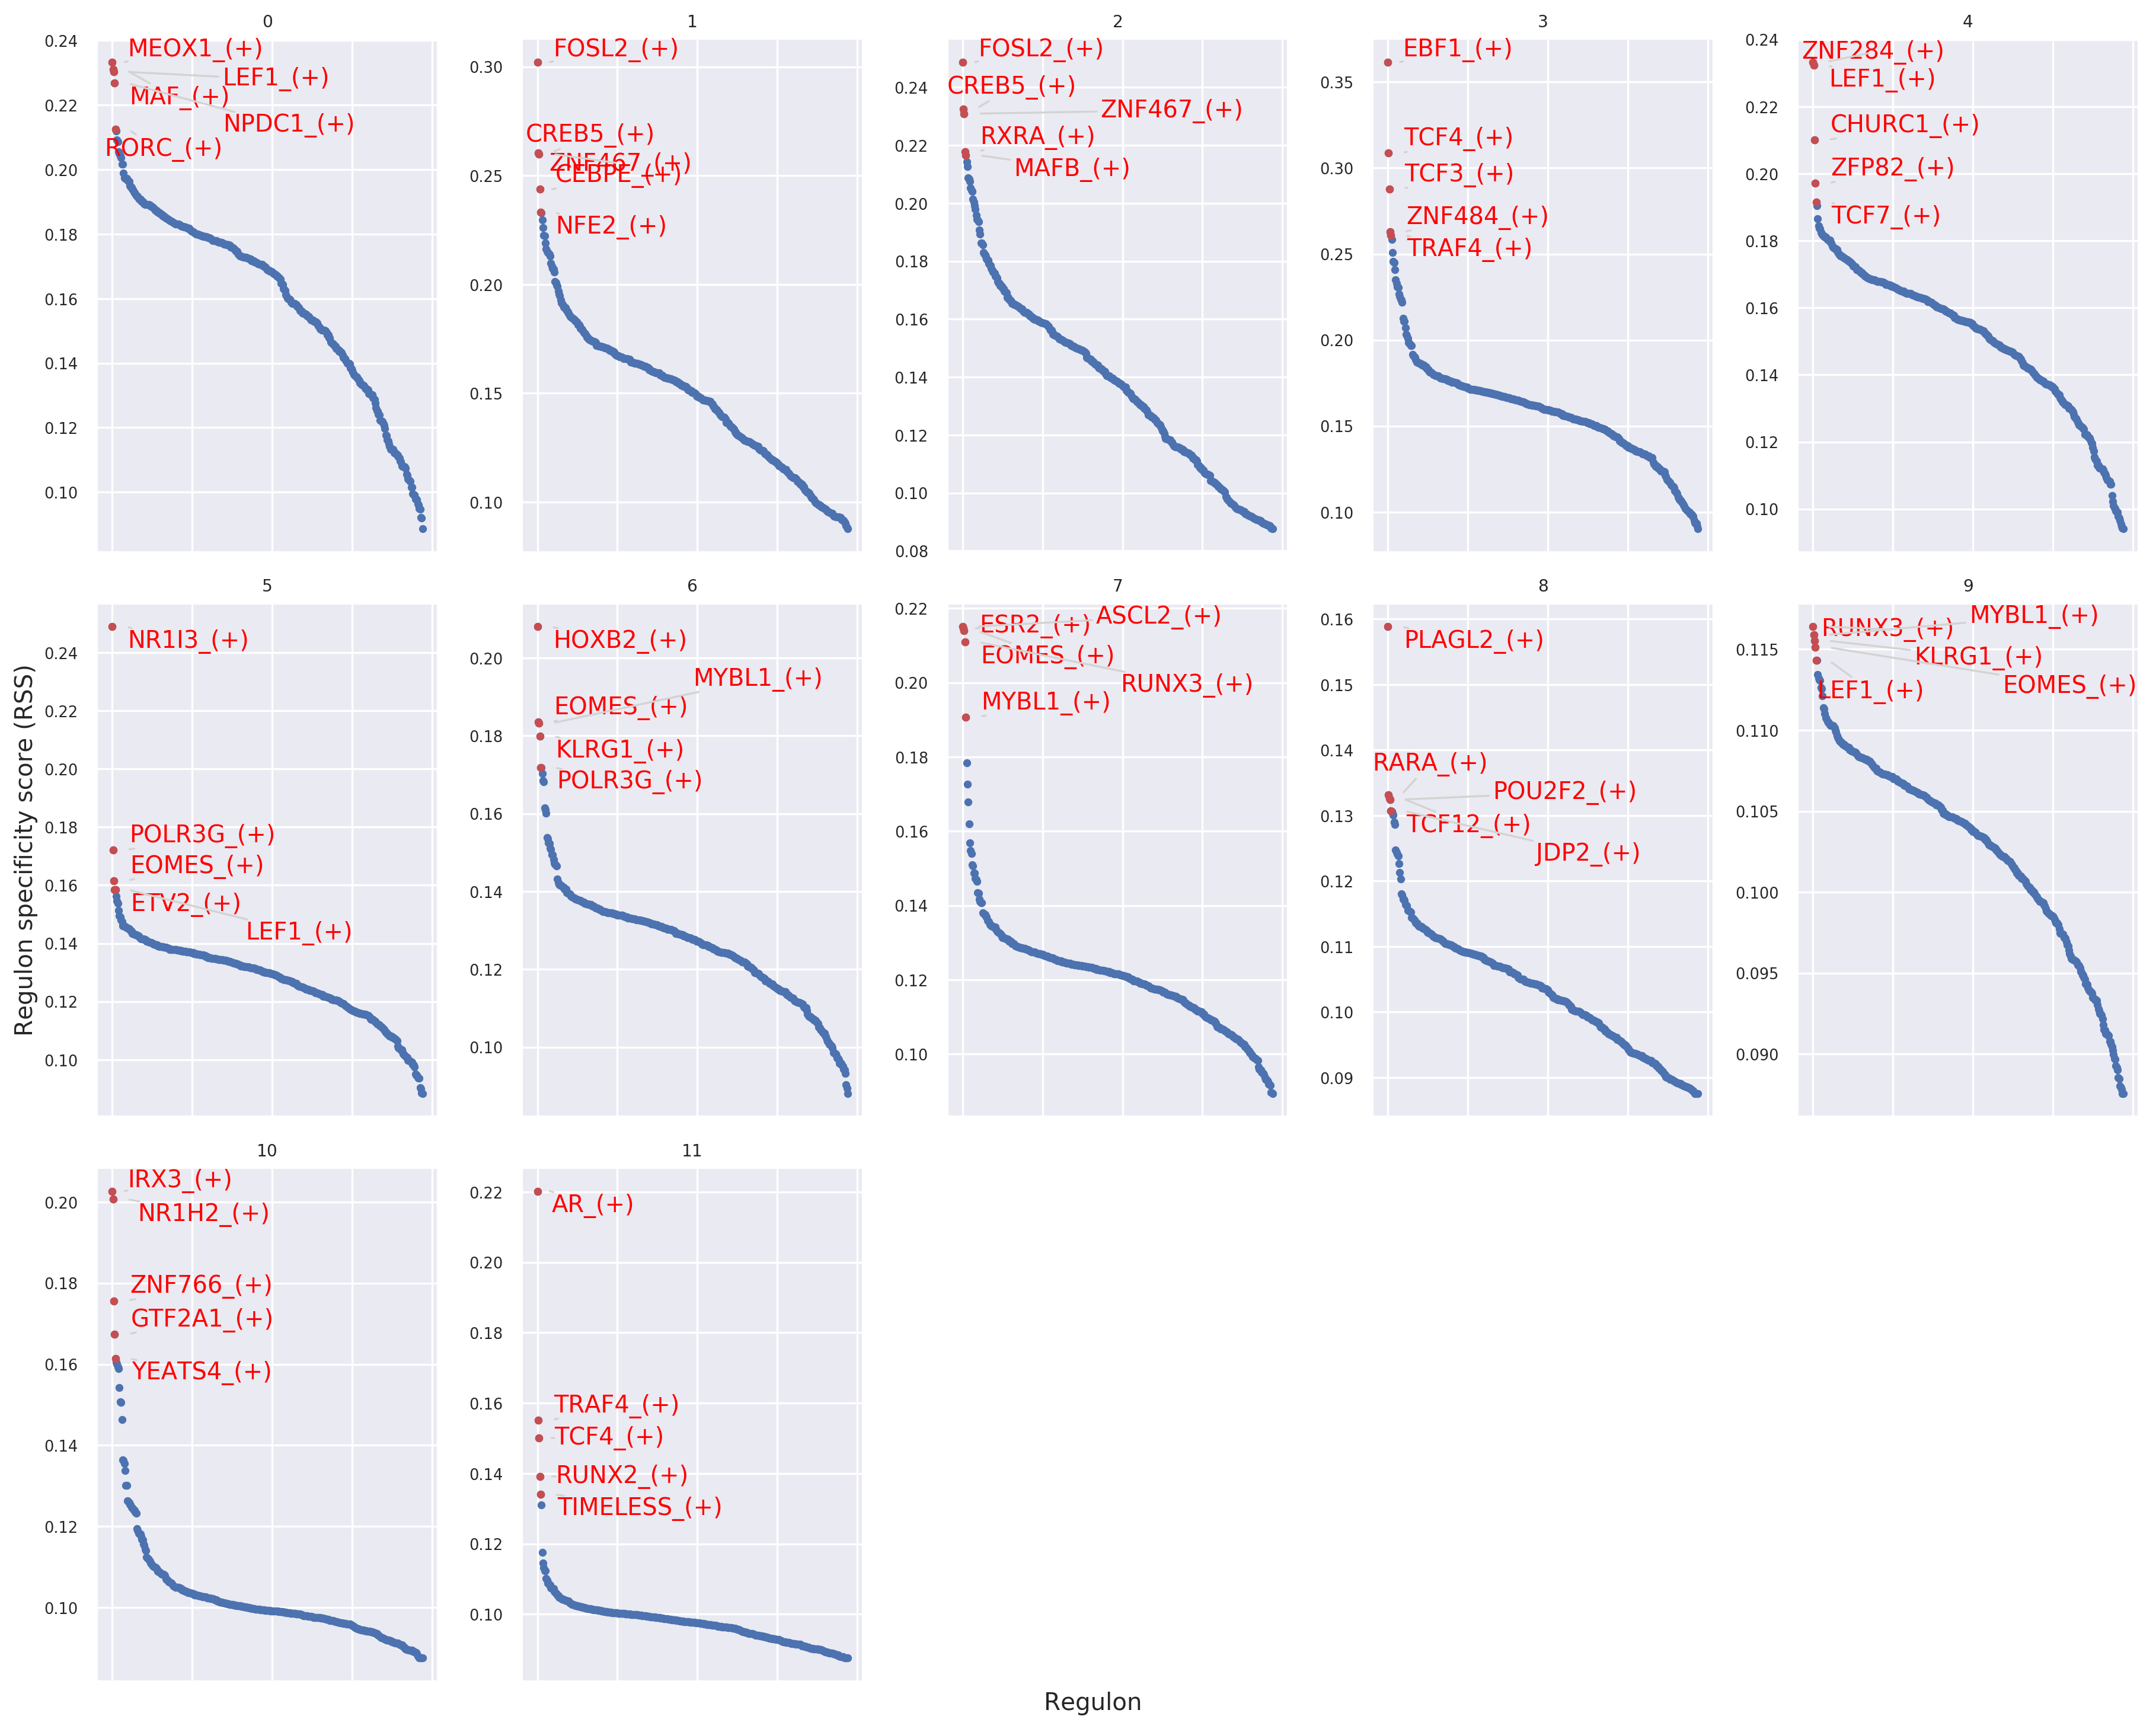

In [20]:
cats = sorted( list(set(cellAnnot['Louvain_clusters_Scanpy'])), key=int )

fig = plt.figure(figsize=(15, 12))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_louvain.T[c]
    ax = fig.add_subplot(3,5,num)
    plot_rss(rss_louvain, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        #'axes.labelsize': 'x-large',
        #'axes.titlesize':'x-large',
        'xtick.labelsize':'large',
        'ytick.labelsize':'large'
        })
plt.savefig("PBMC10k_Louvain-RSS-top5.png", dpi=150, bbox_inches = "tight")
plt.show()

### Select the top 5 regulons from each cell type

In [21]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_louvain.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

Aggregate the AUC matrix by cell type:

In [22]:
auc_mtx_louvain = auc_mtx.groupby(cellAnnot['Louvain_clusters_Scanpy'],axis=0).mean()
auc_mtx_louvain

AHR_(+)    AR_(+)  ARNT_(+)  ARNTL_(+)  ARNTL2_(+)  \
Louvain_clusters_Scanpy                                                        
0                        0.036419  0.000637  0.008515   0.033383    0.007542   
1                        0.073126  0.000415  0.010611   0.019140    0.006034   
10                       0.043612  0.003733  0.015152   0.017239    0.010114   
11                       0.045981  0.048484  0.008329   0.019044    0.027386   
2                        0.070012  0.000276  0.006213   0.017180    0.003246   
3                        0.038684  0.000492  0.012913   0.029235    0.037648   
4                        0.035497  0.000937  0.013225   0.032792    0.011732   
5                        0.033783  0.000595  0.009623   0.032068    0.010805   
6                        0.034252  0.001251  0.008940   0.036395    0.009793   
7                        0.029431  0.001985  0.008113   0.037073    0.012887   
8                        0.046874  0.000153  0.005846   0.017440    0.003336   
9                        0.036173  0.000000  0.006444   0.031815    0.011614   

                         ASCL2_(+)  ATF1_(+)  ATF2_(+)  ATF3_(+)  ATF4_(+)  \
Louvain_clusters_Scanpy                                                      
0                         0.029093  0.042787  0.049322  0.039698  0.059068   
1                         0.011412  0.029952  0.046687  0.071674  0.051801   
10                        0.026808  0.027108  0.012007  0.035133  0.059507   
11                        0.009905  0.035774  0.037929  0.043213  0.064420   
2                         0.010714  0.029082  0.049210  0.069158  0.053505   
3                         0.016239  0.039760  0.041091  0.037220  0.056413   
4                         0.024085  0.044492  0.052599  0.038127  0.056533   
5                         0.049146  0.042139  0.050006  0.037129  0.057129   
6                         0.073765  0.041334  0.052940  0.039875  0.058720   
7                         0.150823  0.041613  0.039562  0.036347  0.053435   
8                         0.021901  0.031815  0.035114  0.051658  0.050508   
9                         0.050187  0.039199  0.054159  0.039435  0.060515   

                           ...     ZNF775_(+)  ZNF8_(+)  ZNF81_(+)  \
Louvain_clusters_Scanpy    ...                                       
0                          ...       0.006666  0.013615   0.031881   
1                          ...       0.004036  0.010326   0.010273   
10                         ...       0.008968  0.005219   0.017114   
11                         ...       0.000192  0.004727   0.016532   
2                          ...       0.001994  0.004738   0.008168   
3                          ...       0.011619  0.028266   0.041350   
4                          ...       0.013807  0.018654   0.035807   
5                          ...       0.004822  0.015058   0.029645   
6                          ...       0.003003  0.013117   0.023032   
7                          ...       0.001786  0.011795   0.018760   
8                          ...       0.004159  0.004300   0.011755   
9                          ...       0.004834  0.012819   0.033390   

                         ZNF816_(+)  ZNF83_(+)  ZNF831_(+)  ZNF91_(+)  \
Louvain_clusters_Scanpy                                                 
0                          0.032933   0.016182    0.115630   0.048963   
1                          0.009316   0.003741    0.028676   0.022764   
10                         0.047433   0.015073    0.018298   0.016069   
11                         0.011547   0.005764    0.031275   0.028970   
2                          0.006322   0.001751    0.028879   0.021527   
3                          0.041418   0.013944    0.069662   0.043249   
4                          0.044713   0.021470    0.099425   0.053406   
5                          0.050567   0.024087    0.101271   0.048980   
6                          0.044180   0.022557    0.125810   0.042861   
7                          0

### Create a heatmap of the top 5 regulons for each cell type, showing the aggregate AUC values

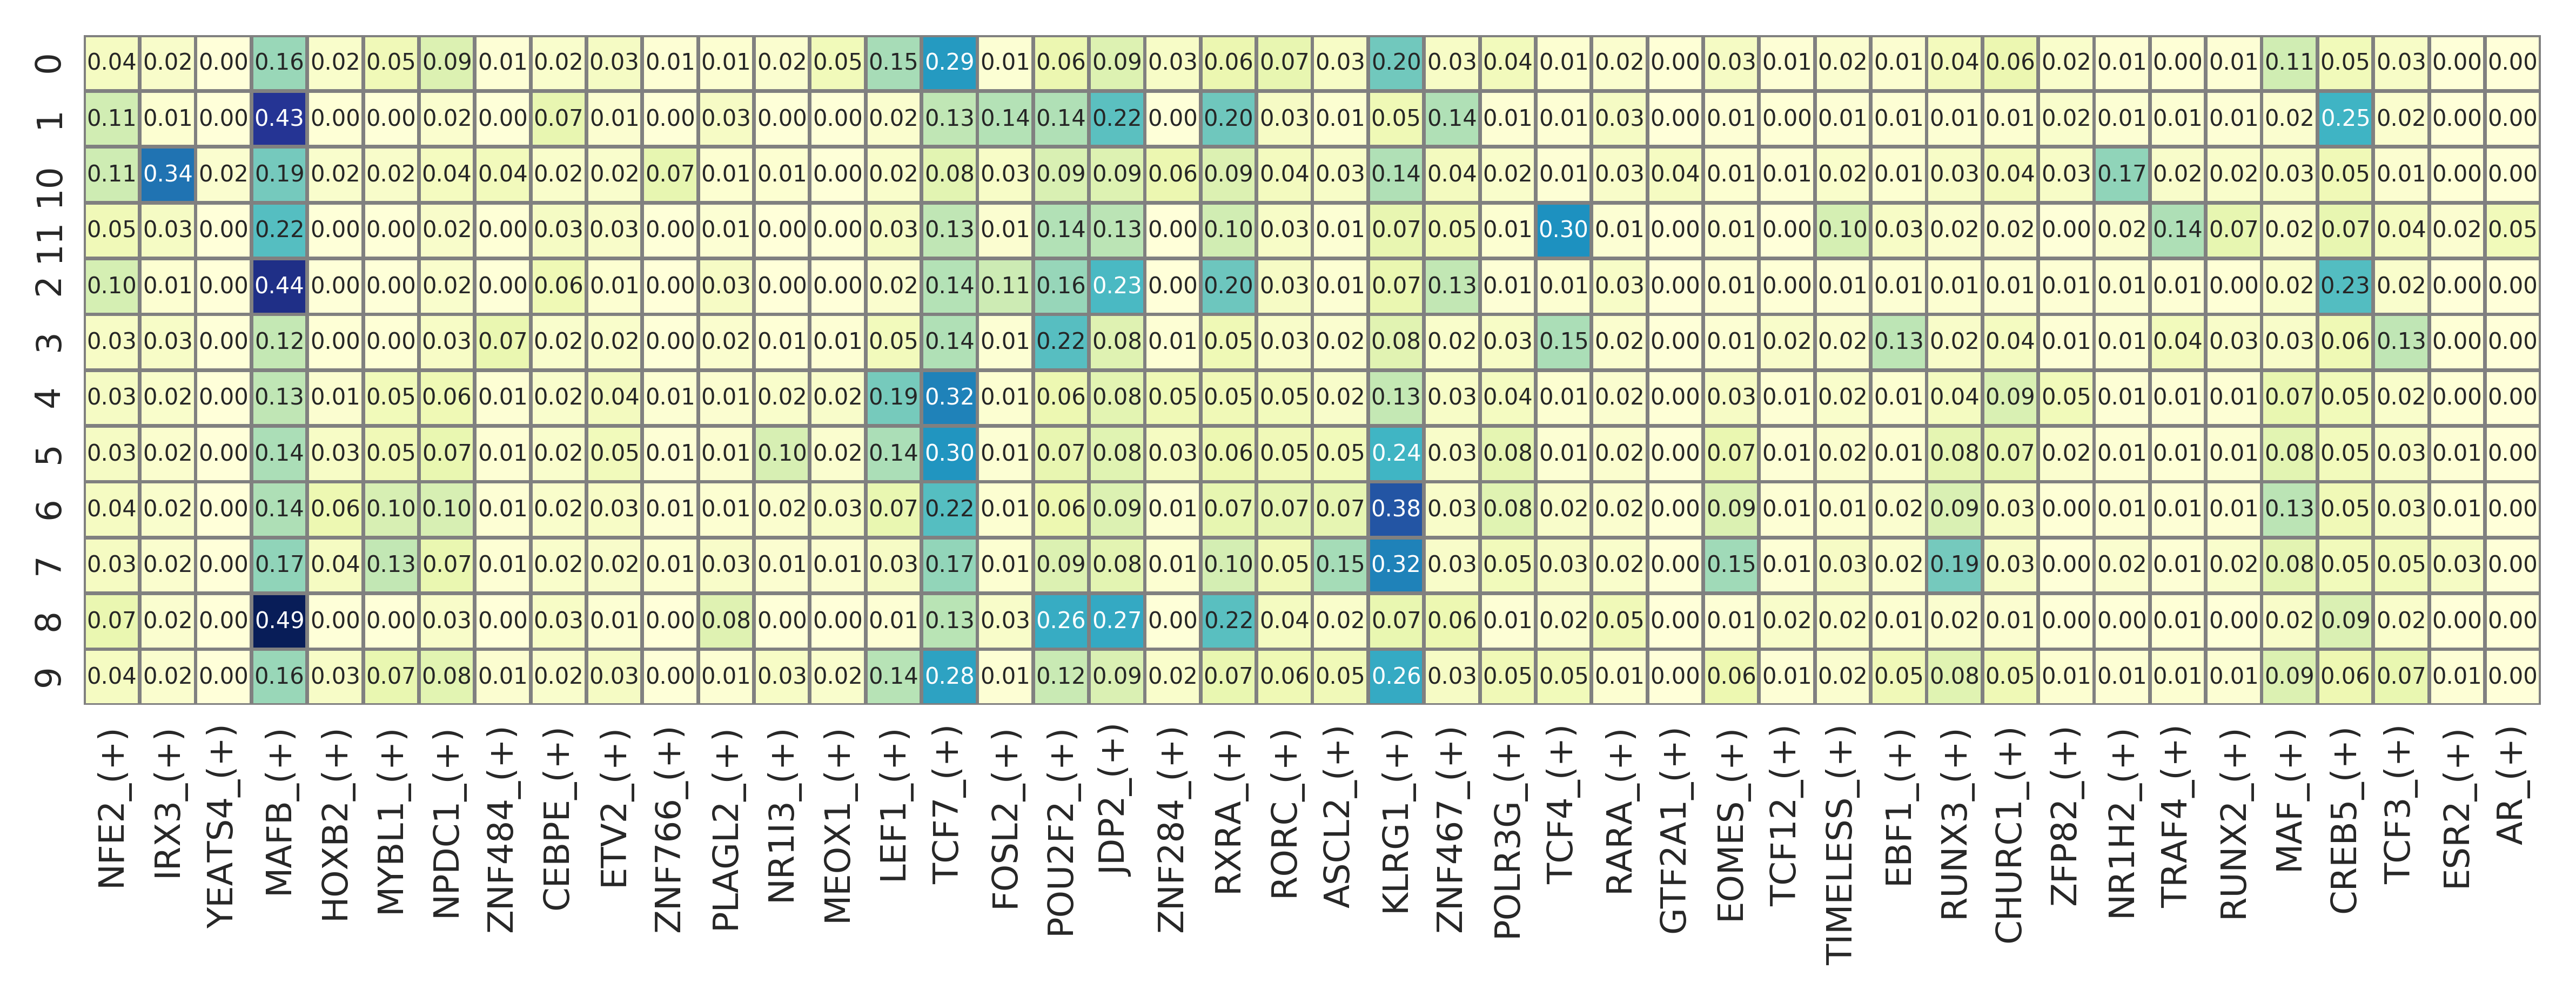

In [25]:
fig, ax = plt.subplots(1, 1, figsize = (8,12), dpi=300)
sns.heatmap(auc_mtx_louvain[topreg], ax=ax, annot=True, fmt=".2f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
            cmap="YlGnBu", annot_kws={"size": 5})
ax.tick_params(axis='both', which='major', pad=-2)
sns.set(font_scale=0.7)
ax.set_ylabel('')    
ax.set_xlabel('')

plt.tight_layout()
plt.savefig("PBMC10k_Louvain-AUC-heatmap-top5.png", dpi=150, bbox_inches = "tight")
plt.show()

#### Add clustering to the heatmap

Text(0.5, 90.49999999999983, '')

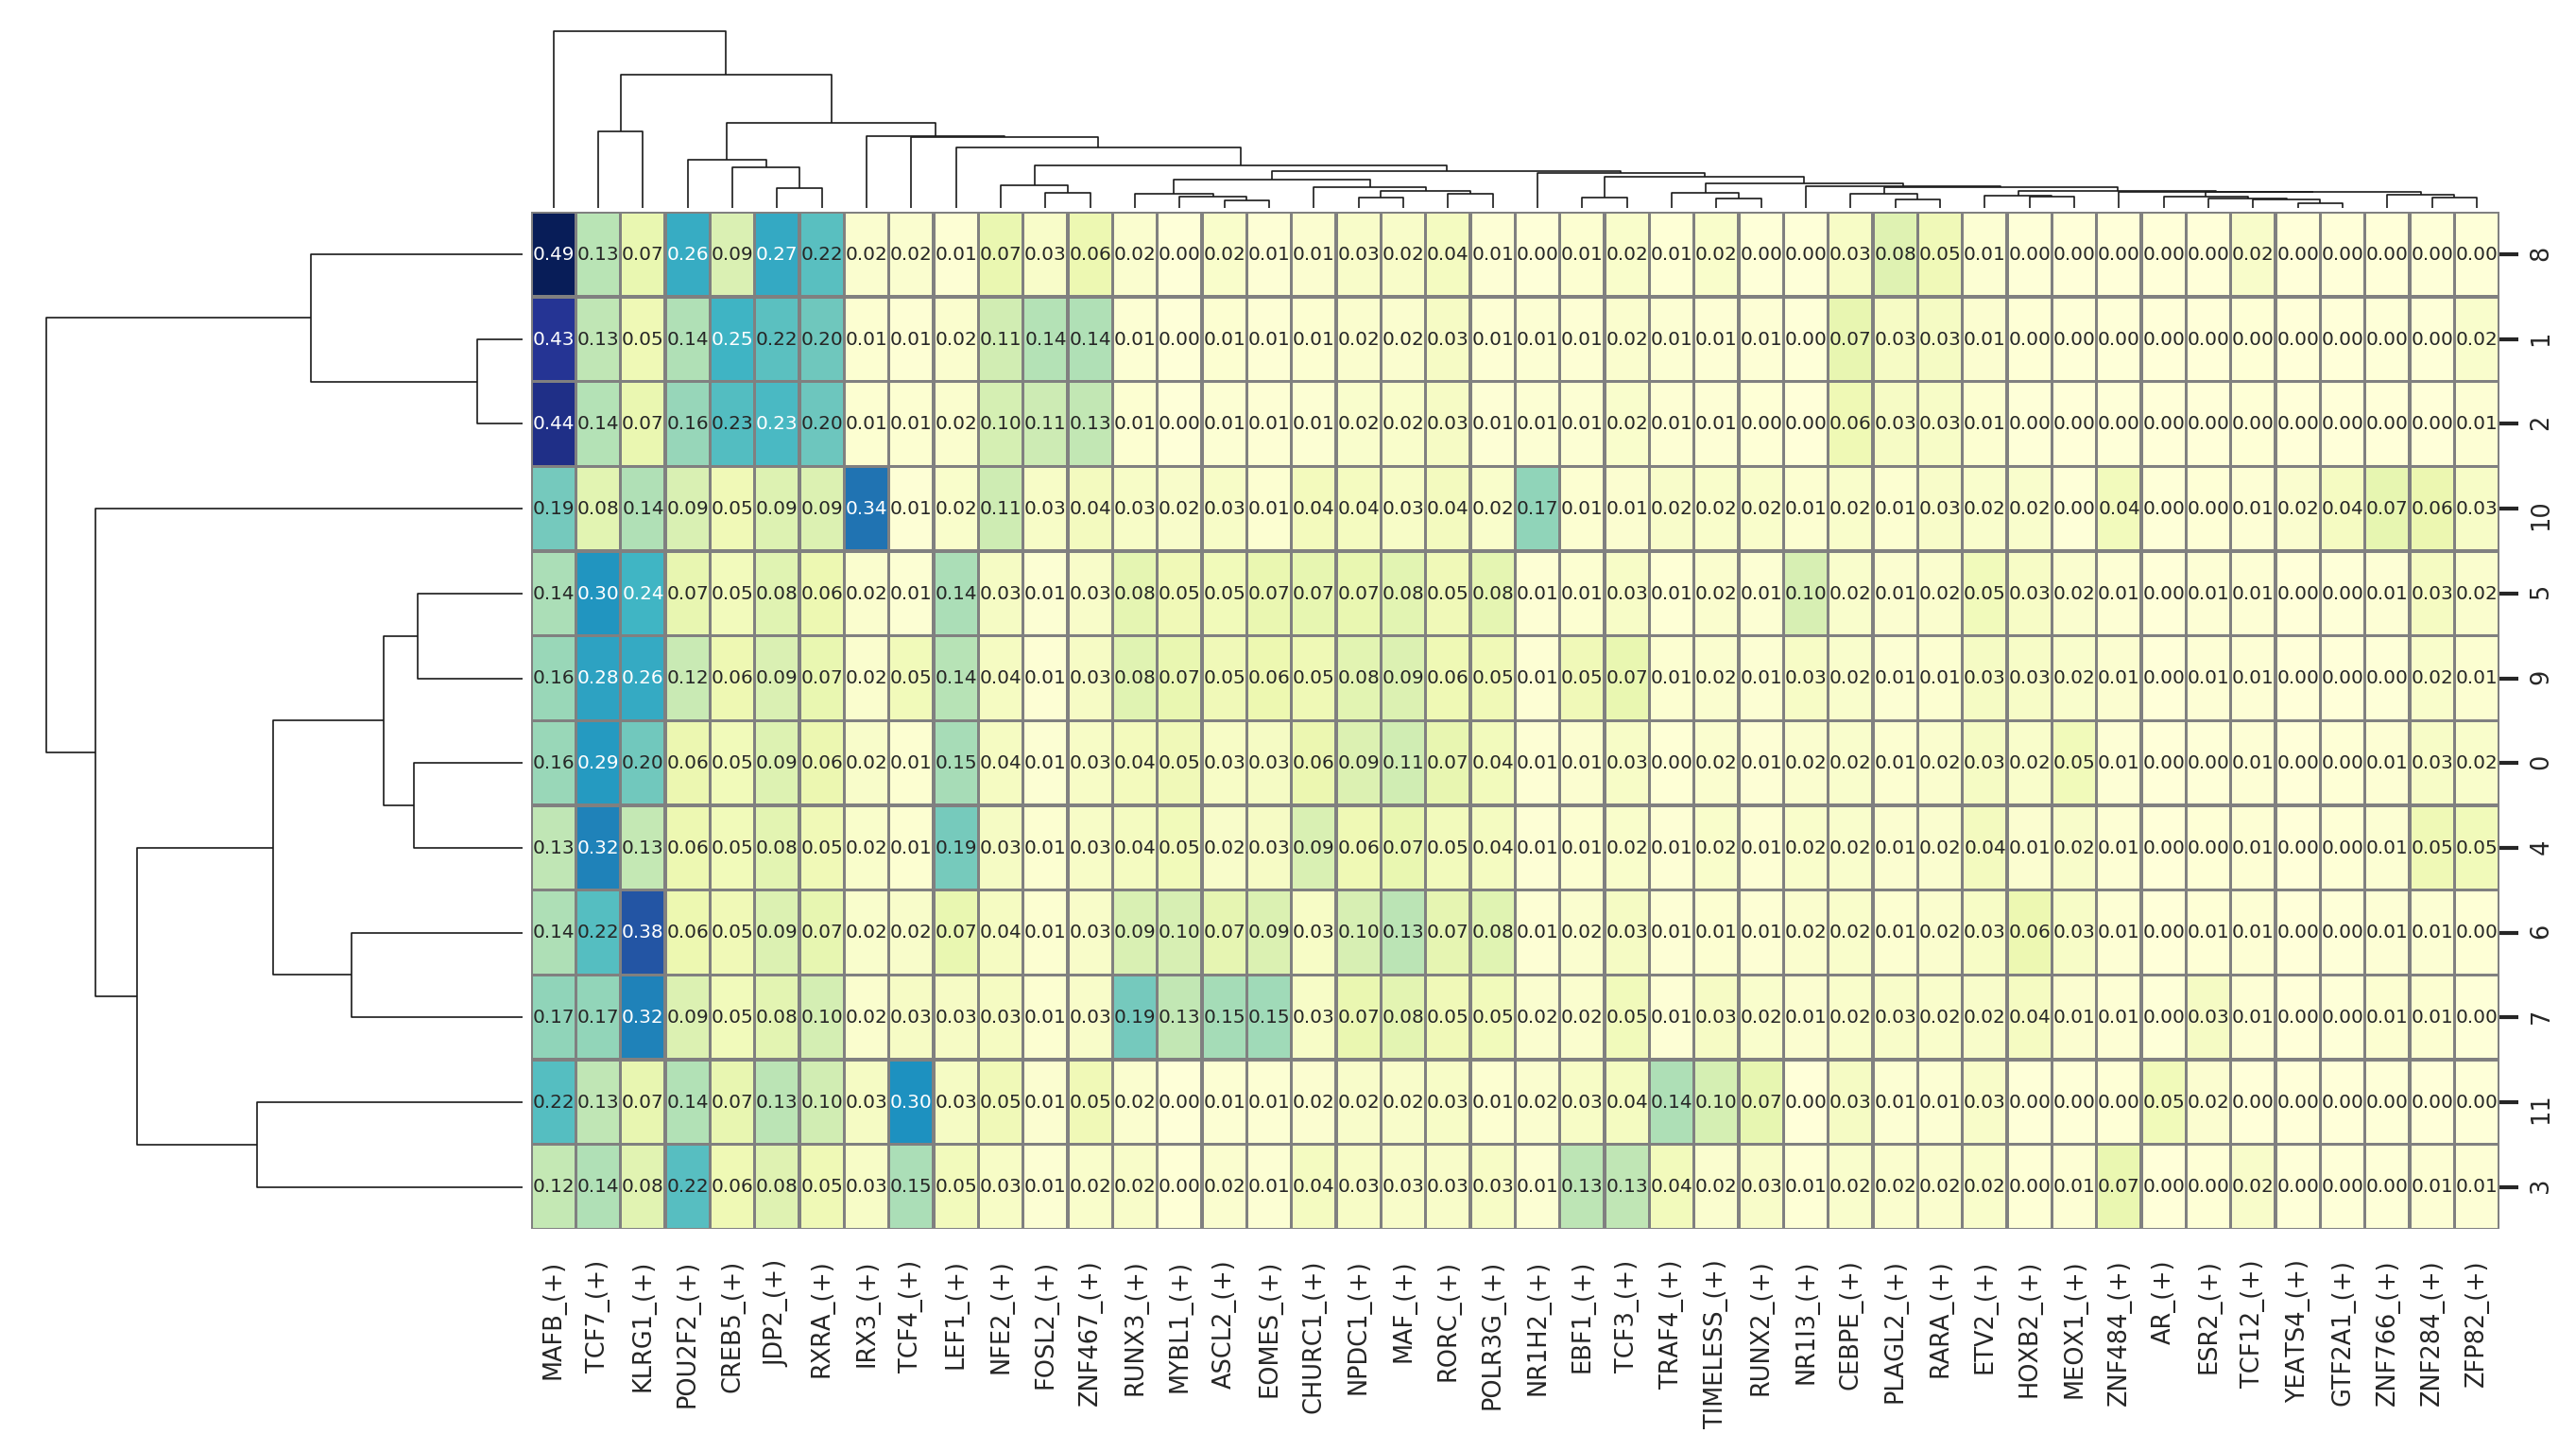

In [26]:
g = sns.clustermap(auc_mtx_louvain[topreg], annot=True, fmt=".2f", linewidths=.7, cbar=False, square=False, linecolor='gray', 
            cmap="YlGnBu", annot_kws={"size": 6}, figsize=(14,7) )
sns.set(font_scale=0.7)
g.cax.set_visible(False)
g.ax_heatmap.set_ylabel('')    
g.ax_heatmap.set_xlabel('')    

# Further exploration of modules directly from the network inference output

In [20]:
adjacencies = pd.read_csv("adj.tsv", index_col=False, sep='\t')

Create the modules:

In [21]:
from pyscenic.utils import modules_from_adjacencies
modules = list(modules_from_adjacencies(adjacencies, exprMat))

/usr/local/lib/python3.6/site-packages/pyscenic/utils.py:138: RuntimeWarning: invalid value encountered in greater
  regulations = (rhos > rho_threshold).astype(int) - (rhos < -rho_threshold).astype(int)
/usr/local/lib/python3.6/site-packages/pyscenic/utils.py:138: RuntimeWarning: invalid value encountered in less
  regulations = (rhos > rho_threshold).astype(int) - (rhos < -rho_threshold).astype(int)


#### pick out modules for ETS1:

In [22]:
tf = 'EBF1'
tf_mods = [ x for x in modules if x.transcription_factor==tf ]

for i,mod in enumerate( tf_mods ):
    print( f'{tf} module {str(i)}: {len(mod.genes)} genes' )
print( f'{tf} regulon: {len(regulons[tf+"_(+)"])} genes' )

EBF1 module 0: 537 genes
EBF1 module 1: 297 genes
EBF1 module 2: 51 genes
EBF1 module 3: 85 genes
EBF1 module 4: 168 genes
EBF1 module 5: 468 genes
EBF1 regulon: 72 genes


write these modules, and the regulon to files:

In [23]:
for i,mod in enumerate( tf_mods ):
    with open( tf+'_module_'+str(i)+'.txt', 'w') as f:
        for item in mod.genes:
            f.write("%s\n" % item)
            
with open( tf+'_regulon.txt', 'w') as f:
    for item in regulons[tf+'_(+)']:
        f.write("%s\n" % item)

### These module files can be further explored in **[iRegulon](http://iregulon.aertslab.org/).**

A detailed iRegulon tutorial is available [here](http://iregulon.aertslab.org/tutorial.html)

This can produce, for example, the following image:

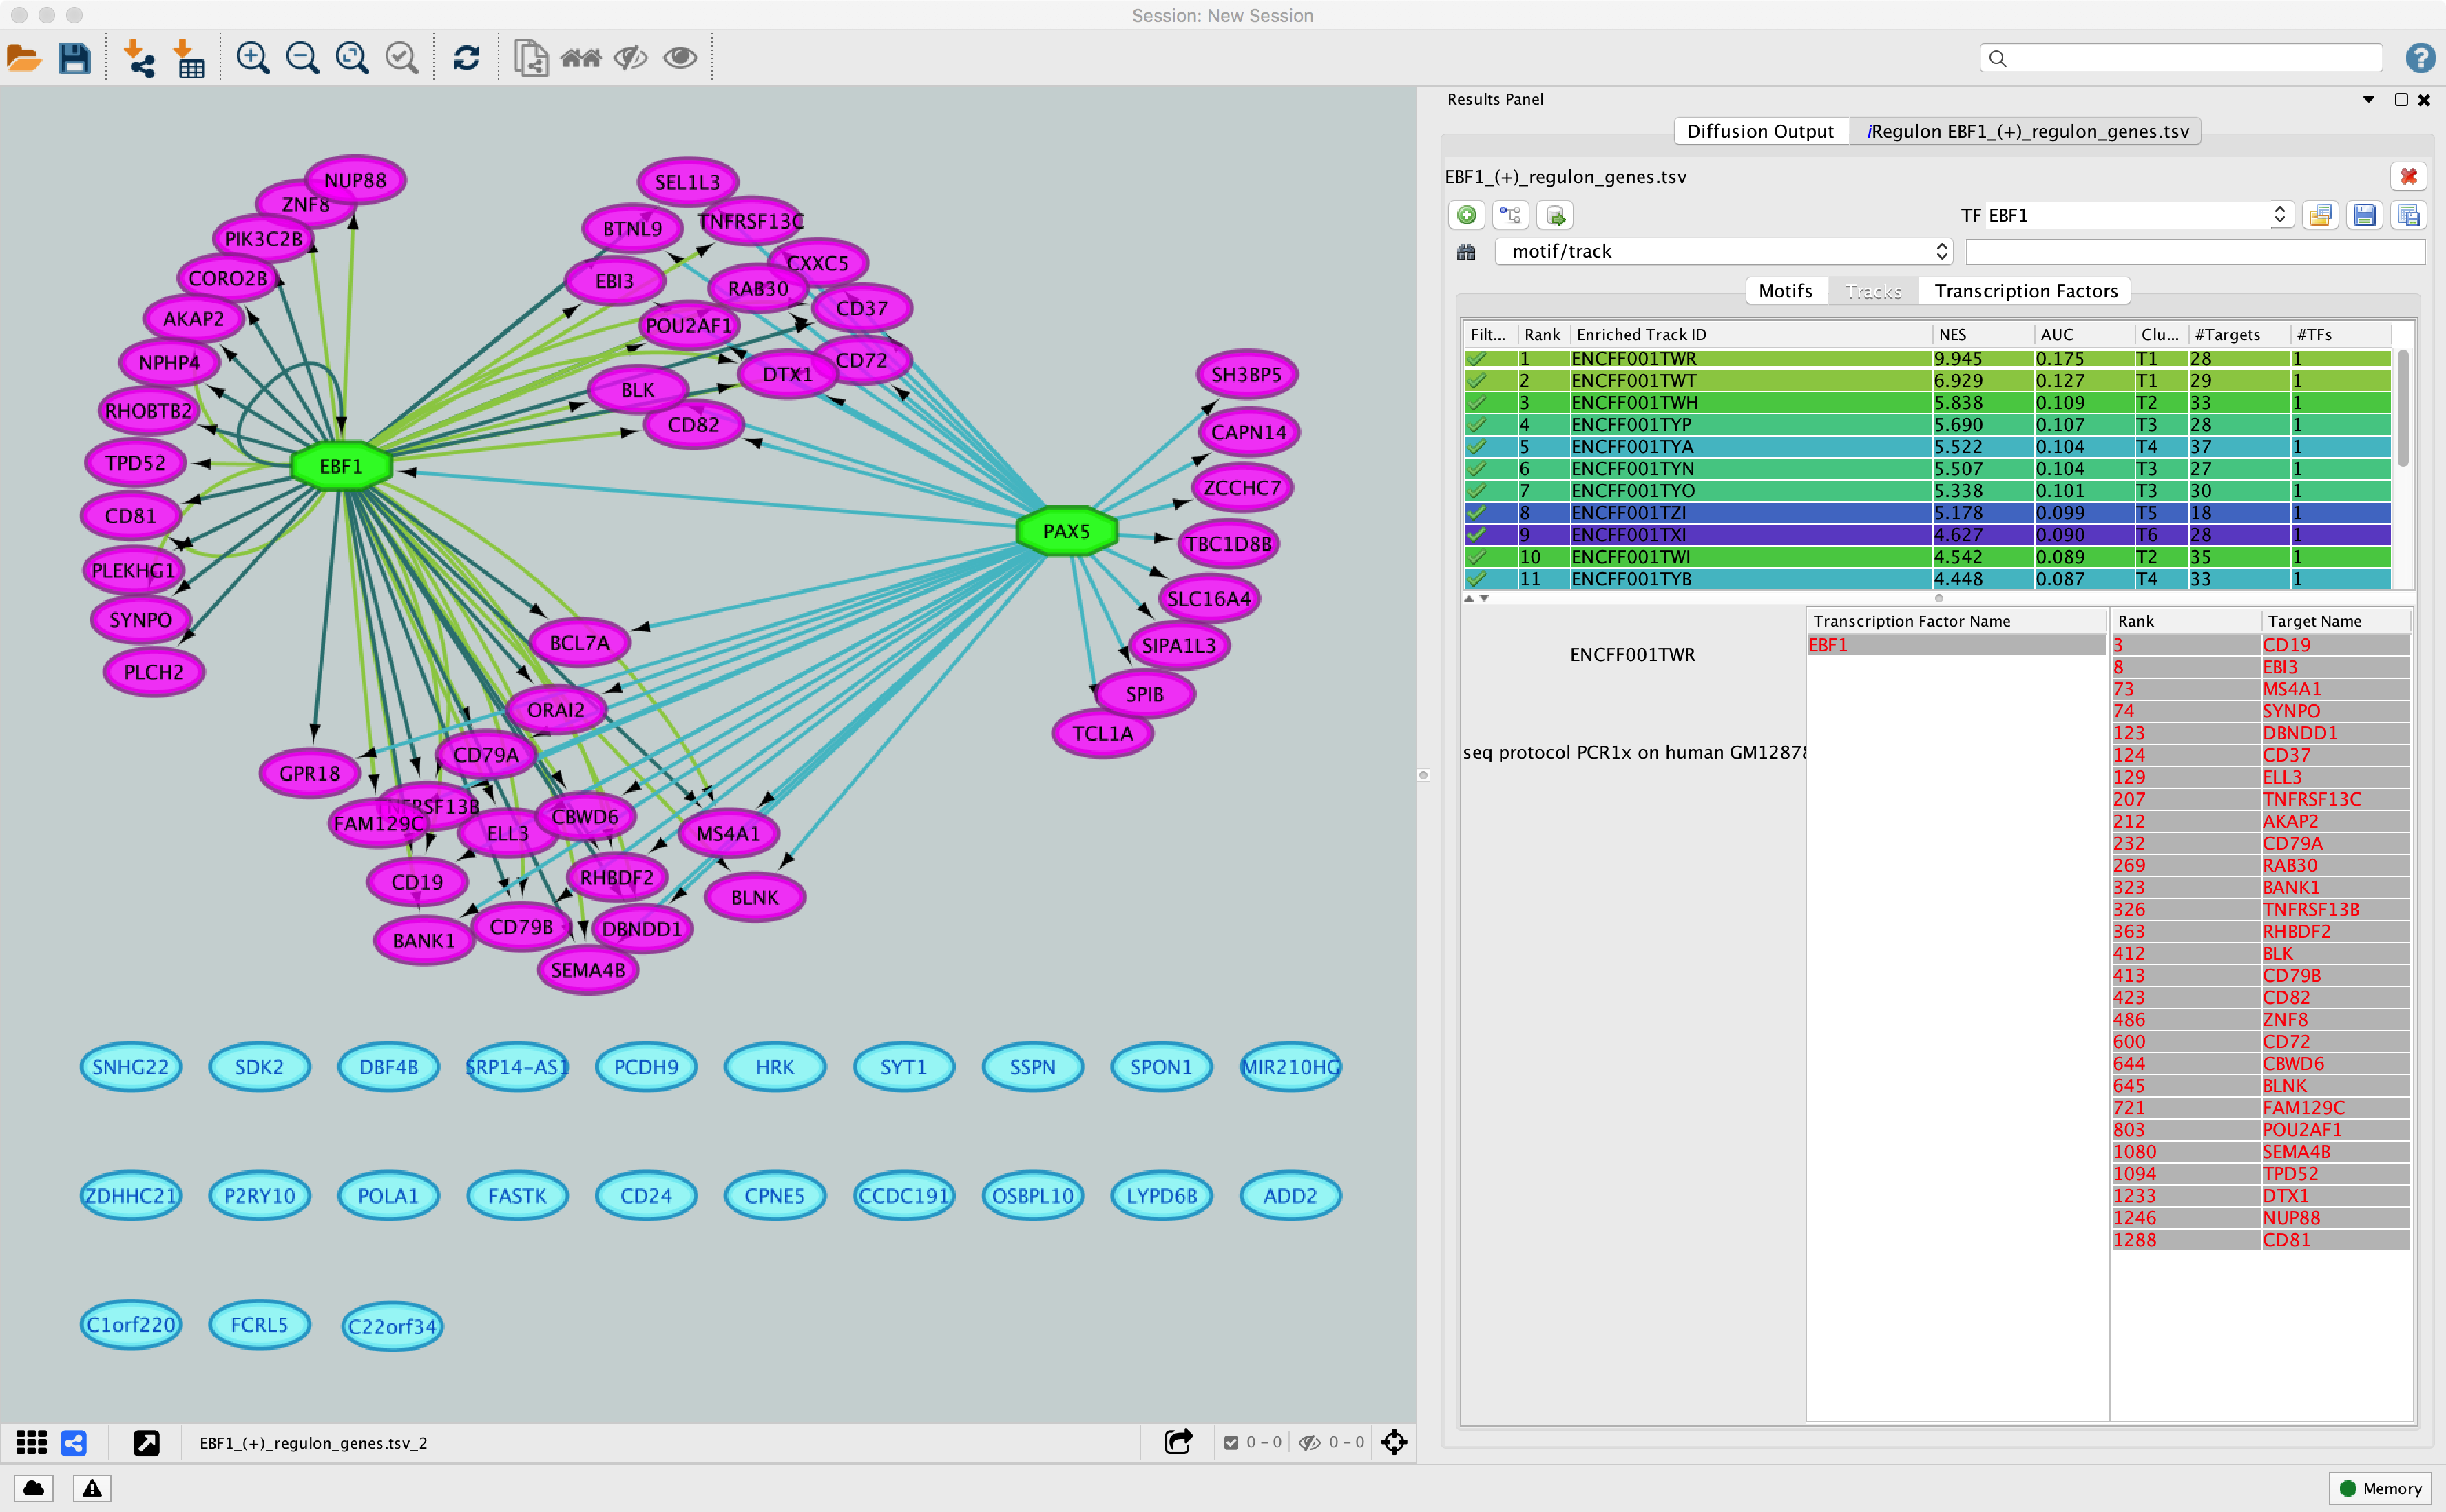

In [29]:
from IPython.display import display, Image
display(Image(filename='iRegulon_screenshot_PBMC10k-EBF1.png'))

# Using region-based information to refine modules

Tracks will be available soon on the [cisTarget database download page](https://resources.aertslab.org/cistarget/)